In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from builtins import range, input
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Embedding, Dot, Add, Flatten, Dense, Concatenate 
from keras.regularizers import l2
from keras.optimizers import SGD, Adam
from keras.layers import Dropout, BatchNormalization, Activation
from scipy.sparse import lil_matrix, csr_matrix

In [41]:
def get_userId(info):
    userId, movieId, rating, timestamp = info.split("::")
    return int(userId)

def get_movieId(info):
    userId, movieId, rating, timestamp = info.split("::")
    return int(movieId)

def get_rating(info):
    userId, movieId, rating, timestamp = info.split("::")
    return int(rating)

def get_timestamp(info):
    userId, movieId, rating, timestamp = info.split("::")
    return int(timestamp)

# load in the data
df = pd.read_csv('/content/drive/My Drive/Dataset/ratings.dat')
df.columns = ['ratings_info']

df['userId'] = df.ratings_info.apply(get_userId)
df['movieId'] = df.ratings_info.apply(get_movieId)
df['rating'] = df.ratings_info.apply(get_rating)
df['timestamp'] = df.ratings_info.apply(get_timestamp)
df.drop('ratings_info', axis=1, inplace=True)
print(df.count())
df.head()

userId       1000208
movieId      1000208
rating       1000208
timestamp    1000208
dtype: int64


,userId,movieId,rating,timestamp
0,1,661,3,978302109
1,1,914,3,978301968
2,1,3408,4,978300275
3,1,2355,5,978824291
4,1,1197,3,978302268


In [0]:
N = df.userId.max() + 1 # number of users
M = df.movieId.max() + 1 # number of movies

# split into train and test
df = shuffle(df)
cutoff = int(0.8*len(df))
df_train = df.iloc[:cutoff]
df_test = df.iloc[cutoff:]

In [0]:
# initialize variables
K = 10 # latent dimensionality
mu = df_train.rating.mean()
epochs = 10
reg = 0.0001 # regularization penalty


## deep learning model

In [0]:
# keras model
u = Input(shape=(1,))
m = Input(shape=(1,))
u_embedding = Embedding(N, K)(u) # (N, 1, K)
m_embedding = Embedding(M, K)(m) # (N, 1, K)
u_embedding = Flatten()(u_embedding) # (N, K)
m_embedding = Flatten()(m_embedding) # (N, K)
x = Concatenate()([u_embedding, m_embedding]) # (N, 2K)

# the neural network
x = Dense(300)(x)
x = Activation('relu')(x)
x = Dense(1)(x)

model_deep = Model(inputs=[u, m], outputs=x)

In [45]:
model_deep.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_40 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_33 (Embedding)        (None, 1, 10)        60410       input_39[0][0]                   
__________________________________________________________________________________________________
embedding_34 (Embedding)        (None, 1, 10)        39530       input_40[0][0]                   
___________________________________________________________________________________________

In [0]:
model_deep.compile(
  loss='mae',
  #optimizer='adam',
  optimizer=Adam(lr=0.01),
  #optimizer=SGD(lr=0.08, momentum=0.9),
  metrics=['mae'],
)

In [47]:
r_deep = model_deep.fit(
  x=[df_train.userId.values, df_train.movieId.values],
  y=df_train.rating.values - mu,
  epochs=epochs,
  batch_size=512,
  validation_data=(
    [df_test.userId.values, df_test.movieId.values],
    df_test.rating.values - mu
  )
)


Train on 800166 samples, validate on 200042 samples
Epoch 1/10
800166/800166 [==============================] - 10s 12us/step - loss: 0.7183 - mean_absolute_error: 0.7183 - val_loss: 0.6900 - val_mean_absolute_error: 0.6900
Epoch 2/10
800166/800166 [==============================] - 10s 12us/step - loss: 0.6824 - mean_absolute_error: 0.6824 - val_loss: 0.6814 - val_mean_absolute_error: 0.6814
Epoch 3/10
800166/800166 [==============================] - 9s 11us/step - loss: 0.6697 - mean_absolute_error: 0.6697 - val_loss: 0.6786 - val_mean_absolute_error: 0.6786
Epoch 4/10
800166/800166 [==============================] - 9s 11us/step - loss: 0.6628 - mean_absolute_error: 0.6628 - val_loss: 0.6762 - val_mean_absolute_error: 0.6762
Epoch 5/10
800166/800166 [==============================] - 9s 11us/step - loss: 0.6581 - mean_absolute_error: 0.6581 - val_loss: 0.6753 - val_mean_absolute_error: 0.6753
Epoch 6/10
800166/800166 [==============================] - 9s 11us/step - loss: 0.6542 - m

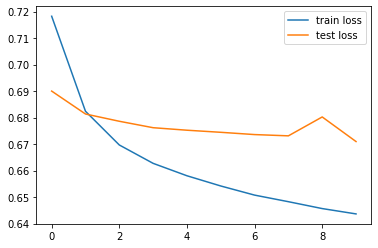

In [48]:
# plot losses
plt.plot(r_deep.history['loss'], label="train loss")
plt.plot(r_deep.history['val_loss'], label="test loss")
plt.legend()



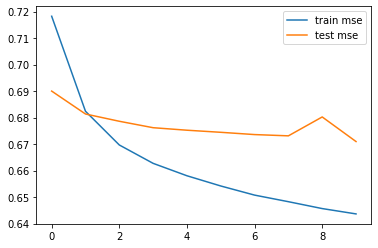

In [49]:
# plot mse
plt.plot(r_deep.history['mean_absolute_error'], label="train mse")
plt.plot(r_deep.history['val_mean_absolute_error'], label="test mse")
plt.legend()


In [0]:
# keras model
u = Input(shape=(1,))
m = Input(shape=(1,))
u_embedding = Embedding(N, K)(u) # (N, 1, K)
m_embedding = Embedding(M, K)(m) # (N, 1, K)
u_embedding = Flatten()(u_embedding) # (N, K)
m_embedding = Flatten()(m_embedding) # (N, K)
x = Concatenate()([u_embedding, m_embedding]) # (N, 2K)

# the neural network
x = Dense(300)(x)
x = Activation('relu')(x)
x = Dense(1)(x)

model_deep2 = Model(inputs=[u, m], outputs=x)

In [0]:
model_deep2.compile(
  loss='mae',
  #optimizer='adam',
  optimizer=Adam(lr=0.01),
  #optimizer=SGD(lr=0.08, momentum=0.9),
  metrics=['mae'],
)

In [52]:
r_deep2 = model_deep2.fit(
  x=[df_train.userId.values, df_train.movieId.values],
  y=df_train.rating.values - mu,
  epochs=15,
  batch_size=512,
  validation_data=(
    [df_test.userId.values, df_test.movieId.values],
    df_test.rating.values - mu
  )
)


Train on 800166 samples, validate on 200042 samples
Epoch 1/15
800166/800166 [==============================] - 10s 13us/step - loss: 0.7190 - mean_absolute_error: 0.7190 - val_loss: 0.6922 - val_mean_absolute_error: 0.6922
Epoch 2/15
800166/800166 [==============================] - 9s 12us/step - loss: 0.6823 - mean_absolute_error: 0.6823 - val_loss: 0.6847 - val_mean_absolute_error: 0.6847
Epoch 3/15
800166/800166 [==============================] - 9s 12us/step - loss: 0.6703 - mean_absolute_error: 0.6703 - val_loss: 0.6783 - val_mean_absolute_error: 0.6783
Epoch 4/15
800166/800166 [==============================] - 9s 12us/step - loss: 0.6629 - mean_absolute_error: 0.6629 - val_loss: 0.6779 - val_mean_absolute_error: 0.6779
Epoch 5/15
800166/800166 [==============================] - 10s 12us/step - loss: 0.6574 - mean_absolute_error: 0.6574 - val_loss: 0.6762 - val_mean_absolute_error: 0.6762
Epoch 6/15
800166/800166 [==============================] - 9s 11us/step - loss: 0.6534 - m

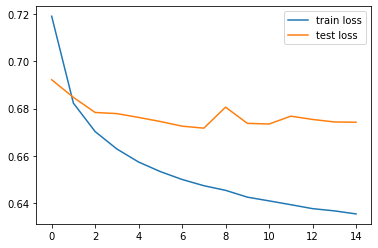

In [53]:
# plot losses
plt.plot(r_deep2.history['loss'], label="train loss")
plt.plot(r_deep2.history['val_loss'], label="test loss")
plt.legend()


In [54]:
# keras model
u = Input(shape=(1,))
m = Input(shape=(1,))
u_embedding = Embedding(N, K)(u) # (N, 1, K)
m_embedding = Embedding(M, K)(m) # (N, 1, K)
u_embedding = Flatten()(u_embedding) # (N, K)
m_embedding = Flatten()(m_embedding) # (N, K)
x = Concatenate()([u_embedding, m_embedding]) # (N, 2K)

# the neural network
x = Dense(200)(x)
x = Activation('softmax')(x)
x = Dense(400)(x)
x = Activation('relu')(x)
x = Dense(1)(x)

model_deep3 = Model(inputs=[u, m], outputs=x)
model_deep3.summary()
model_deep3.compile(
  loss='mae',
  #optimizer='adam',
  optimizer=Adam(lr=0.01),
  #optimizer=SGD(lr=0.08, momentum=0.9),
  metrics=['mae'],
)

r_deep = model_deep3.fit(
  x=[df_train.userId.values, df_train.movieId.values],
  y=df_train.rating.values - mu,
  epochs=20,
  batch_size=512,
  validation_data=(
    [df_test.userId.values, df_test.movieId.values],
    df_test.rating.values - mu
  )
)

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_43 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_44 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_37 (Embedding)        (None, 1, 10)        60410       input_43[0][0]                   
__________________________________________________________________________________________________
embedding_38 (Embedding)        (None, 1, 10)        39530       input_44[0][0]                   
___________________________________________________________________________________________

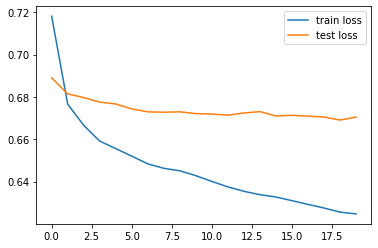

In [55]:
# plot losses
plt.plot(r_deep.history['loss'], label="train loss")
plt.plot(r_deep.history['val_loss'], label="test loss")
plt.legend()

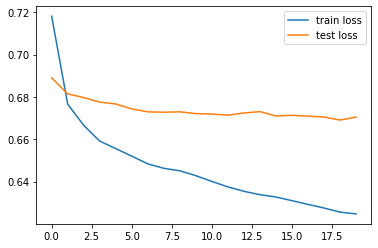

In [56]:
# plot losses
plt.plot(r_deep.history['mean_absolute_error'], label="train loss")
plt.plot(r_deep.history['val_mean_absolute_error'], label="test loss")
plt.legend()